In [6]:
!pip install transformers

In [7]:
# imports
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelWithLMHead
from matplotlib import pyplot as plt

from google.colab import files
files.upload()  # load dataGeneration.py
files.upload()  # load waypointNet.py
from dataGeneration import generateTestBatch
from waypointNet import WaypointNet, listToTensor

Saving waypointNet.py to waypointNet (1).py


Saving dataGeneration.py to dataGeneration (1).py


In [8]:
# import the pretrained models
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelWithLMHead.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# investigating BERT model output size
baseModel = model.bert

sampleText = "go forward 3 meters"
enc = tokenizer.encode_plus(sampleText)
X = torch.tensor(enc["input_ids"]).unsqueeze(0)
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0)

out = baseModel(X, attn)
print(out[0].shape)
print("Batch size, length of tokenized text, model output size\n")

# testing larger batch
sampleBatch = ["go forward three meters", "turn right", "go right 1 meter"]
enc = tokenizer.batch_encode_plus(sampleBatch)
X = listToTensor(enc["input_ids"])
attn = listToTensor(enc["attention_mask"])

out = baseModel(X, attn)
print(out[0].shape)
print("Batch size, length of tokenized text, model output size\n")

torch.Size([1, 6, 768])
Batch size, length of tokenized text, model output size

torch.Size([3, 6, 768])
Batch size, length of tokenized text, model output size



cuda:0
[10] loss: 3.278
[20] loss: 2.106
[30] loss: 2.029
[40] loss: 1.657
[50] loss: 1.241
[60] loss: 1.055
[70] loss: 0.940
[80] loss: 0.777
[90] loss: 0.661
[100] loss: 0.594
[110] loss: 0.473
[120] loss: 0.525
[130] loss: 0.452
[140] loss: 0.357
[150] loss: 0.372
[160] loss: 0.370
[170] loss: 0.388
[180] loss: 0.326
[190] loss: 0.309
[200] loss: 0.328
[210] loss: 0.271
[220] loss: 0.283
[230] loss: 0.242
[240] loss: 0.230
[250] loss: 0.307
[260] loss: 0.230
[270] loss: 0.310
[280] loss: 0.196
[290] loss: 0.211
[300] loss: 0.220
[310] loss: 0.208
[320] loss: 0.188
[330] loss: 0.254
[340] loss: 0.187
[350] loss: 0.195
[360] loss: 0.156
[370] loss: 0.185
[380] loss: 0.148
[390] loss: 0.192
[400] loss: 0.171
[410] loss: 0.144
[420] loss: 0.138
[430] loss: 0.133
[440] loss: 0.147
[450] loss: 0.128
[460] loss: 0.141
[470] loss: 0.137
[480] loss: 0.119
[490] loss: 0.111
[500] loss: 0.145


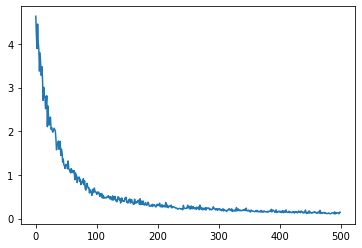

In [11]:
# training model
if torch.cuda.is_available():  
  device = torch.device("cuda:0") 
else:  
  device = torch.device("cpu")
print(device)

net = WaypointNet(baseModel)
net = net.to(device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
objectiveValues = []

# TODO: make this work with batch data generation
# Then move to GPU
for epoch in range(500):  # generate new test data
  text, labels = generateTestBatch(1000)
  labels = torch.tensor(labels, dtype = torch.float)
  enc = tokenizer.batch_encode_plus(text)
  X = listToTensor(enc["input_ids"])
  attn = listToTensor(enc["attention_mask"])

  X = X.to(device)
  attn = attn.to(device)
  labels = labels.to(device)

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = net((X, attn))
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()

  # print statistics
  if ((epoch + 1) % 10 == 0):
    print('[%d] loss: %.3f' % (epoch + 1, loss.item()))
  objectiveValues.append(loss.item())

plt.plot(objectiveValues)

In [ ]:
# save model
torch.save(net.state_dict(), "waypointBERT.pth")
files.download("waypointBERT.pth")

In [ ]:
# ONLY RUN THIS IF YOU GET AN OUT OF MEMORY ERROR WHEN TESTING
# this seems to be the only way to fix a CUDA out of memory error from
# increasing batch size too high
import gc
del X
del attn
del labels

gc.collect()